In [1]:
#!pip install lightgbm --upgrade

In [1]:
# %matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import imblearn
import plotly.graph_objs as go
import optuna
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna.integration.lightgbm as lgb
import lightgbm
from lightgbm import early_stopping
from lightgbm import log_evaluation
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
#Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2

pd.options.display.float_format = '{:,.3}'.format

C:\Users\Daniel Ji\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [3]:
data.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [4]:
category_cols = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education','Income']

binary_cols = ['Diabetes_binary','HighBP', 'HighChol', 'CholCheck',  'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','DiffWalk', 'Sex']
stats_cols = ['BMI','GenHlth','MentHlth','PhysHlth','Age','Education','Income']
cat_all = category_cols.copy()

In [5]:
scaler = MinMaxScaler()
df_filtered = data[binary_cols + stats_cols]
df_normalized = pd.DataFrame(scaler.fit_transform(df_filtered[stats_cols]), columns=stats_cols)
df_combined = pd.concat([data[binary_cols], df_normalized], axis=1)

mean_diabetes = df_combined[df_combined['Diabetes_binary'] == 1].mean()[1:]
mean_nondiabetes = df_combined[df_combined['Diabetes_binary'] == 0].mean()[1:]

According to the radar plot, people with diabetes:
   - had stroke
   - smoke more often
   - have higher level of cholestrol
   - have higher blood pressure
   - have lower income
   - have lower education level
   - are older
   - have higher BMI
   - have difficulty to walk
   - have lower level of GenHlth, MentHlth, and PhysHlth

## Train-Test Split

In [6]:
#ID_col = null
target = 'Diabetes_binary'
train, test = train_test_split(data)

X_train = train.drop(columns=[target]).copy()
X_test = test.drop(columns=[target]).copy()

y_train = train['Diabetes_binary'].copy()
y_test = test['Diabetes_binary'].copy()

In [7]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [8]:
models = [#DecisionTreeClassifier(),RandomForestClassifier(),SVC(),
          LogisticRegression(),XGBClassifier(),LGBMClassifier()]
scoring = ['accuracy','f1','precision','recall']
models_columns = ['Name','fit_time','test_accuracy',
                  'test_f1','test_precision',
                 'test_recall']
models_chart = pd.DataFrame(columns = models_columns)

In [9]:
row_index = 0
for model in models:
    model_name = model.__class__.__name__
    models_chart.loc[row_index,'Name'] = model_name
    
    cv_results = cross_validate(model,X_train,y_train,cv =3,scoring = scoring,return_train_score = True,n_jobs=-1)
    models_chart.loc[row_index,'fit_time'] = cv_results['fit_time'].mean()
    models_chart.loc[row_index,'test_accuracy'] = cv_results['test_accuracy'].mean()
    #models_chart.loc[row_index,'train_accuracy'] = cv_results['train_accuracy'].mean()
    models_chart.loc[row_index,'test_f1'] = cv_results[ 'test_f1'].mean()
    #models_chart.loc[row_index,'train_f1'] = cv_results['train_f1'].mean()
    models_chart.loc[row_index,'test_precision'] = cv_results['test_precision'].mean()
    #models_chart.loc[row_index,'train_precision'] = cv_results['train_precision'].mean()
    models_chart.loc[row_index,'test_recall'] = cv_results['test_recall'].mean()
    #models_chart.loc[row_index,'train_recall'] = cv_results['train_recall'].mean()
    
    row_index +=1

In [10]:
models_chart.sort_values(by='test_accuracy',ascending = False)

,Name,fit_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
1,XGBClassifier,29.8,0.898,0.93,0.872,0.926,0.964,0.963,0.834,0.893
2,LGBMClassifier,3.94,0.894,0.925,0.868,0.921,0.961,0.956,0.83,0.889
0,LogisticRegression,3.06,0.749,0.749,0.756,0.756,0.736,0.736,0.777,0.778


We applied oversampling and the result accuracy, f1, precision, and recall are all better off.

Fit the three models

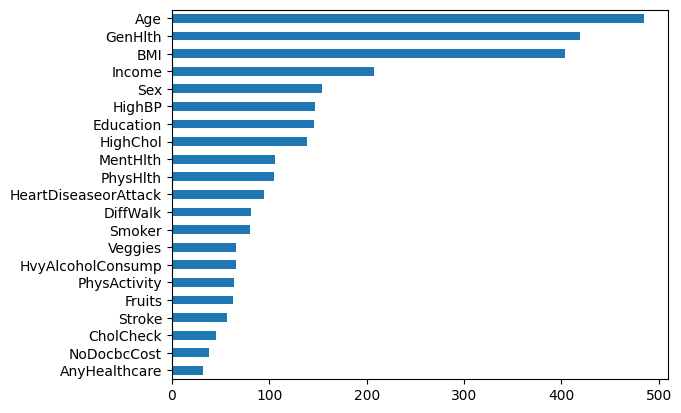

In [31]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
lr = LogisticRegression()
lr.fit(X_train,y_train)
#plot the graph of feature importances of lgbm
feature_importances = pd.Series(lgbm.feature_importances_, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending= True)
sorted_importances.plot(kind='barh')
plt.show()

In [12]:
# # hyperparamter tuning
# import sklearn.datasets

# dtrain = lgb.Dataset(X_train, label=y_train)
# dval = lgb.Dataset(X_test, label=y_test)

# params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "verbosity": -1,
#     "boosting_type": "gbdt",
# }

# lgbm_tuned = lgb.train(
#     params,
#     dtrain,
#     valid_sets=[dtrain, dval],
#     callbacks=[early_stopping(100), log_evaluation(100)],
# )

# prediction = np.rint(lgbm_tuned.predict(X_test, num_iteration=lgbm_tuned.best_iteration))
# accuracy = accuracy_score(y_test, prediction)

# best_params = lgbm_tuned.params
# print("Best params:", best_params)
# print("  Accuracy = {}".format(accuracy))
# #lgbm_tuned = LGBMClassifier(best_params)

In [49]:
# import the pre-trained model
filename = 'LightGBM_model.sav'
lgbm_tuned = pickle.load(open(filename, 'rb'))

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

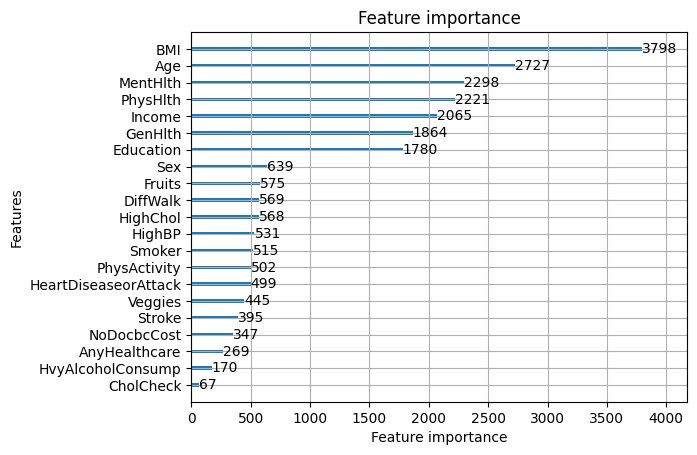

In [15]:
#lgbm_tuned = LGBMClassifier(**best_params).fit(X_train,y_train)
lightgbm.plot_importance(lgbm_tuned)

In [55]:
models = [#DecisionTreeClassifier(),RandomForestClassifier(),SVC(),
          LogisticRegression(),XGBClassifier(),LGBMClassifier(),lgbm_tuned]
scoring = ['accuracy','f1','precision','recall','neg_log_loss']
models_columns = ['Name','fit_time','test_accuracy',
                  'test_f1','test_precision',
                 'test_recall','test_log_loss']
models_chart = pd.DataFrame(columns = models_columns)

row_index = 0
for model in models:
    model_name = model.__class__.__name__
    models_chart.loc[row_index,'Name'] = model_name
    
    cv_results = cross_validate(model,X_train,y_train,cv =3,scoring = scoring,return_train_score = True,n_jobs=-1)
    models_chart.loc[row_index,'fit_time'] = cv_results['fit_time'].mean()
    models_chart.loc[row_index,'test_accuracy'] = cv_results['test_accuracy'].mean()
    #models_chart.loc[row_index,'train_accuracy'] = cv_results['train_accuracy'].mean()
    models_chart.loc[row_index,'test_f1'] = cv_results[ 'test_f1'].mean()
    #models_chart.loc[row_index,'train_f1'] = cv_results['train_f1'].mean()
    models_chart.loc[row_index,'test_precision'] = cv_results['test_precision'].mean()
    #models_chart.loc[row_index,'train_precision'] = cv_results['train_precision'].mean()
    models_chart.loc[row_index,'test_recall'] = cv_results['test_recall'].mean()
    #models_chart.loc[row_index,'train_recall'] = cv_results['train_recall'].mean()
    models_chart.loc[row_index,'test_log_loss'] = -cv_results['test_neg_log_loss'].mean()
    
    row_index +=1

models_chart.sort_values(by='test_accuracy',ascending = False)

,Name,fit_time,test_accuracy,test_f1,test_precision,test_recall,test_log_loss
3,LGBMClassifier,23.2,0.9,0.874,0.966,0.835,0.52
1,XGBClassifier,29.6,0.898,0.872,0.964,0.834,NaN
2,LGBMClassifier,3.59,0.894,0.868,0.961,0.83,0.348
0,LogisticRegression,2.95,0.749,0.756,0.736,0.777,0.513


In [50]:
# Stacking
# probabilities of estimation on train dataset
train_prediction1_proba = lgbm.predict_proba(X_train)[:, 1]
train_prediction2_proba = xgb.predict_proba(X_train)[:, 1]
train_prediction3_proba = lgbm_tuned.predict_proba(X_train)[:, 1]

# probabilities of estimation on test dataset
test_prediction1_proba = lgbm.predict_proba(X_test)[:, 1]
test_prediction2_proba = xgb.predict_proba(X_test)[:, 1]
test_prediction3_proba = lgbm_tuned.predict_proba(X_test)[:, 1]

# stack the probabilities on train and the probabilities on test
train_stack = np.vstack([[train_prediction1_proba], 
                         [train_prediction2_proba], 
                         [train_prediction3_proba]]).T

test_stack = np.vstack([[test_prediction1_proba], 
                        [test_prediction2_proba], 
                        [test_prediction3_proba]]).T

In [56]:
lgbm = LGBMClassifier().fit(X_train, y_train)
lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

(0.9189802790390691, 0.8657363607694734)

In [57]:
lgbm_tuned_model = lgbm_tuned.fit(X_train, y_train)
lgbm_tuned_model.score(X_train, y_train), lgbm_tuned_model.score(X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=4.981663087268992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.981663087268992
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.332570000291688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.332570000291688e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


(0.9256384714574688, 0.8668085777357301)

In [21]:
xgber = XGBClassifier().fit(X_train, y_train)
xgber.score(X_train, y_train), xgber.score(X_test, y_test)

(0.9243673342174256, 0.8671712393566698)

test error performance: XGB > tuned LGBM > LGBM

In [51]:
# Use lgbm as second level model
lgbm_final = lgbm_tuned.fit(train_stack, y_train)
lgbm_final.score(train_stack, y_train), lgbm_final.score(test_stack, y_test)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=4.981663087268992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.981663087268992
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.332570000291688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.332570000291688e-07
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


(0.9261487597245055, 0.8690633869441816)

Stacking increases test accuracy from 86.72% to 86.91%

## Feature Engineering

Lift(Beer→Diaper) = (Confidence (Beer→Diaper))/(Support (Diaper)) \
what we replace to equals: \
lift(feature -> diabetes) = confidence(feature -> diabetes)/support(diabetes) \
confidence (feature -> diabetes) equals (cases containing both feature and diabetes)/(cases containing only feature)

In [25]:
selected_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','Sex']
sup_diabetes = np.mean(data['Diabetes_binary'])

for col in selected_columns:
    confidence = len(data[(data['Diabetes_binary'] == 1.0) & (data[col] == 1.0)])/len(data[col] == 1.0)
    lift = confidence/sup_diabetes
    print('Lift of',col,'is:',lift)

Lift of HighBP is: 0.7526735698523171
Lift of HighChol is: 0.6701182594918803
Lift of CholCheck is: 0.9931816895829798
Lift of Smoker is: 0.5182198834380128
Lift of Stroke is: 0.09245742092457422
Lift of HeartDiseaseorAttack is: 0.22288236292649807
Lift of PhysActivity is: 0.6305381089797998
Lift of Fruits is: 0.5854410682962713
Lift of Veggies is: 0.7564080801222204
Lift of HvyAlcoholConsump is: 0.023538731398178015
Lift of AnyHealthcare is: 0.9597691393651333
Lift of NoDocbcCost is: 0.10586770780286313
Lift of Sex is: 0.47912069258190465


According to the lift scores, no feature significantly affects diabetes positively. We could consider removing NoDocbcCost based on heatmap, feature importance of model, and lift.